In [1]:
#GEREKLİ KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(1)
tf.random.set_seed(1)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#verilerimi csv den okuyorum öncelikle hangi sanatçılarım var bunları belirliyorum 
artists = pd.read_csv('artists.csv')


(50, 8)

In [3]:
#Sanatçıları yaptıkları tablo sayısına göre sıralama ve gösterme işlemi bu da csv den veriyi okuyup aynı isimdeki
#klasöre gidip ordaki verinin sayısının getirilmesiyle gerçekleşiyor.200'den fazla tablosu olanları alıyorum ki işlemler
#hızlıca bitebilsin. Bir öncekinde 2 saate yakın eğitim sürdüğü için.
artists = artists.sort_values(by=['paintings'], ascending=False)
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [4]:
#Sınıfların yani ressamların sınıf ağırlıklarını key value şeklinde ayarlama işlemi 
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

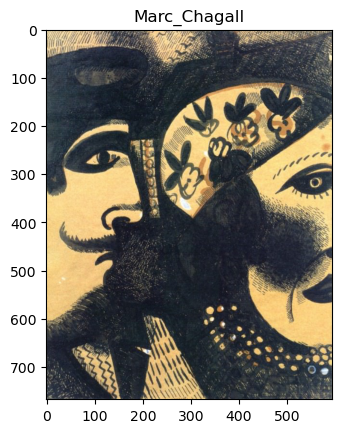

In [6]:
#rasgele bi resmi ekrana basıyorum
#görüntülerin oldukları yerler
images_dir = 'images'
artists_dirs = os.listdir(images_dir)
#csv den okuyup ismini değiştiriyorum
artists_top_name = artists_top['name'].str.replace(' ', '_').values
#csv den okuduğum değeri getirip klasörlerde arıyorum sonra o ressamın klasörüne girip rasgele bir tanesini basıyorum
random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join('images', random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)
image = plt.imread(random_image_file)
plt.imshow(image)
plt.title( random_artist)
plt.show()

In [6]:
# Veri Düzenleme İşlemi (DATA AUGMENTATION) Bu adımda aslında görüntülerden sayısal bilgiler elde ediyoruz model eğitimi için
batch_size = 16 #bir iterasyonda kaç adet verinin gireceği bilgisi
train_input_shape = (224, 224, 3) #verilecek olan inputların şekil bilgisi
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2, # train_test_split işlemi aslında bu kısım %20 ayırdım
                                   rescale=1./255., #görüntülerin boyutlarını 0 ve 1 arasına sıkıştırma (downsampling sanırım)
                                   horizontal_flip=True, #yatay döndürme
                                   vertical_flip=True, #dikey döndürme
                                  )

#bu kısımda ise train datalarının modele verilmek üzere batch yani yığın haline getiriyorum. bir önceki modelde detaylıca yazdım
#adımları tekrar değinmeyeceğim. aynı anda 16 adet görüntü gönderiyorum. subset ile training olduğunu belirtiyorum
train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=16,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )
#bu kısımda ise validatiton datalarının modele verilmek üzere batch yani yığın haline getirilmesi.
#Aynı anda 16 adet görüntü gönderiyorum. subset ile test verisi olduğunu belirtiyorum
valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=16,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )
#bu kısımda model eğitilirken vereceğim datanın büyüklüğü yani train ve test kısmında aslında kaç tane verimin olduğu 
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

Found 3181 images belonging to 11 classes.
Found 790 images belonging to 11 classes.
198 49


In [7]:
# Eğitilmiş bir resnet50 modeli alıyorum ağırlık bilgisi olarak imagenet kullanıyorum
# ağın en üstündeki katmanlarda tamamen bağlantı olmaması için false değer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

#Katmanların yeniden eğitilebilir olacağını belirtiyorum
for layer in base_model.layers:
    layer.trainable = True

In [8]:
#Modelin sonuna ek katman ekliyorum ki fine tuning işlemini yapabilmiş olayım
X = base_model.output
#modelin son katmanının çıktısını alıyorum ve düz bir array haline getiriyorum
X = Flatten()(X)
#512 nöron içeren katman ekledim ki detaylı şekilde modeli eğitebileyim
X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
#Ağdaki bazı nöronların aktif olup, aktivasyonun dengeli olması için relu kullandım
X = Activation('relu')(X)
#tekrar bir katman ekliyorum bu da son katman olacak 
X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
output = Dense(n_classes, activation='softmax')(X)
model = Model(inputs=base_model.input, outputs=output)

In [9]:
#modelimi compile ediyorum derliyorum yeni eklediğim özelliklerle
#öğrenme hızımı düşük veriyorum ki modelim detaylı öğrenebilsin ama falza düşük
#düşük vermek eğitimi uzatabilir. metrik olarak accuracy gösterilmesini istiyorum
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

In [10]:
#Bir metriğin gelişimi durursa öğrenme oranını artırıyorum ki model öğrenmeye devam etsin
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [11]:
# Modelin tüm katmanlarını, kendi eklediğim katmanlarla birlikte eğitiyorum
egitim = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=10,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=False,
                              class_weight=class_weights
                             )

Epoch 1/10
198/198 [==============================] - 427s 2s/step - loss: 1.4952 - accuracy: 0.5017 - val_loss: 2.4886 - val_accuracy: 0.0651 - lr: 1.0000e-04
Epoch 2/10
198/198 [==============================] - 428s 2s/step - loss: 1.0671 - accuracy: 0.7308 - val_loss: 2.5862 - val_accuracy: 0.0625 - lr: 1.0000e-04
Epoch 3/10
198/198 [==============================] - 444s 2s/step - loss: 0.8905 - accuracy: 0.7994 - val_loss: 2.5029 - val_accuracy: 0.1429 - lr: 1.0000e-04
Epoch 4/10
198/198 [==============================] - 446s 2s/step - loss: 0.7832 - accuracy: 0.8442 - val_loss: 2.4425 - val_accuracy: 0.2156 - lr: 1.0000e-04
Epoch 5/10
198/198 [==============================] - 440s 2s/step - loss: 0.6849 - accuracy: 0.8724 - val_loss: 1.5730 - val_accuracy: 0.5319 - lr: 1.0000e-04
Epoch 6/10
198/198 [==============================] - 439s 2s/step - loss: 0.6046 - accuracy: 0.8886 - val_loss: 0.9505 - val_accuracy: 0.8048 - lr: 1.0000e-04
Epoch 7/10
198/198 [====================

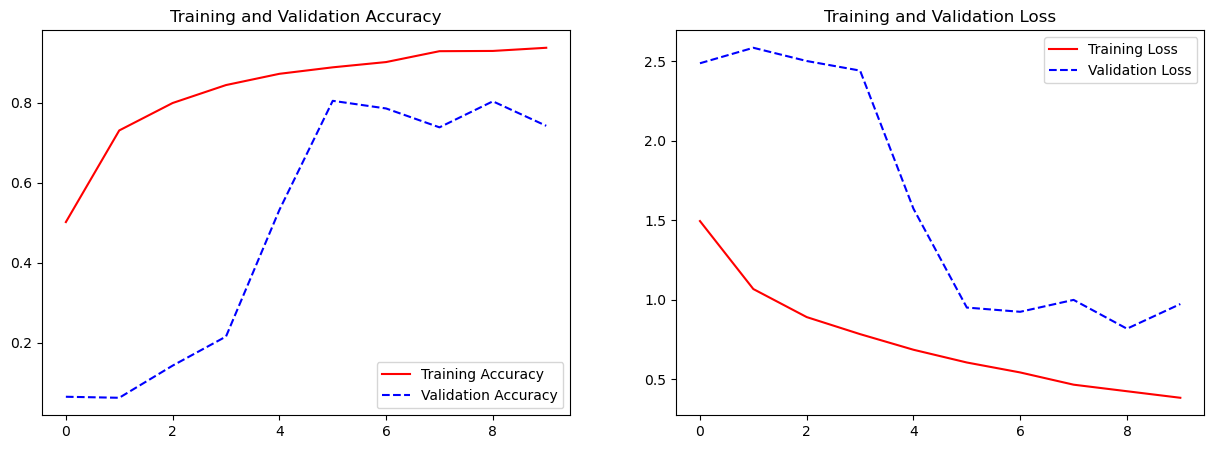

In [12]:
# Öğrenme eğrilerini ekrana pyplot ile bastırıyorum

acc = egitim.history['accuracy']
val_acc = egitim.history['val_accuracy']
loss = egitim.history['loss']
val_loss = egitim.history['val_loss']
epochs = range(len(acc))

fig, axes = plt.subplots(1, 2, figsize=(15,5))

#train ve validation accuracy grafiğim
axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend(loc='best')

#train ve validation loss grafiğim
axes[1].plot(epochs, loss, 'r-', label='Training Loss')
axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend(loc='best')

plt.show()
    


1/1 [==============================] - 1s 514ms/step


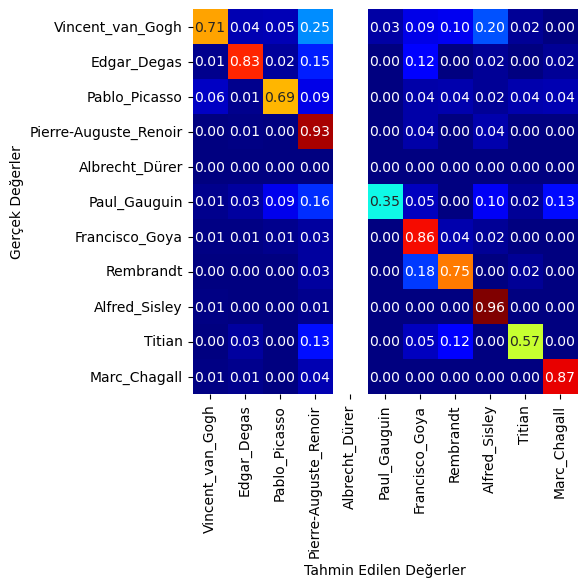

Sınıflandırma Test Sonuçları:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.88      0.71      0.78       171
          Edgar_Degas       0.85      0.83      0.84       139
        Pablo_Picasso       0.80      0.69      0.74        87
Pierre-Auguste_Renoir       0.50      0.93      0.65        67
       Albrecht_Dürer       0.00      0.00      0.00         0
         Paul_Gauguin       0.92      0.35      0.51        62
       Francisco_Goya       0.60      0.86      0.71        57
            Rembrandt       0.72      0.75      0.74        52
        Alfred_Sisley       0.71      0.96      0.82        51
               Titian       0.85      0.57      0.68        51
         Marc_Chagall       0.82      0.87      0.85        47

            micro avg       0.75      0.75      0.75       784
            macro avg       0.70      0.68      0.67       784
         weighted avg       0.79      0.75      0.75       784



In [13]:
# Karmaşıklık matrisini oluşturuyorum

from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def olustur(model, valid_generator, STEP_SIZE_VALID):
    # her verdiğim girdiyi ve sonucunda edilen tahmini dönüyorum ve diziye atıyorum
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # tahmin edilen değerler ve gerçek değerler için diziler
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Bir indisteki maksimum değeri dönmesi için fonksiyon kullanıyorum ve bunu dizi olarak saklıyorum
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Üstteki işlemin aynısı ama bu kez tahmin edilen değerler için yapyıyorum
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Karmaşıklık matrisini ekrana basmak için 
    fig, ax = plt.subplots(figsize=(5,5))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Gerçek Değerler')
    ax.set_xlabel('Tahmin Edilen Değerler')
    plt.show()

    #sklearn den classification_report fonksiyonunu kullanıyorum
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

olustur(model, valid_generator, STEP_SIZE_VALID)